### Zespół 4:
- Jakub Smuga
- Konrad Korus
- Maksym Kazhaiev

## Imports



In [ ]:
!pip install SALib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.8/778.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from SALib.analyze import pawn
from SALib.sample import saltelli
from scipy.stats import ks_2samp
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt

In [ ]:
from enum import Enum

class AnalysisMethod(Enum):
    SOBOL = "Sobol"
    PAWN = "Pawn"

## Helper functions

In [ ]:
random_shuffle_state = 2024

def train_valid_test_split(features, targets, valid_p = 0.1, test_p = 0.3):
  # shuffle the features and targets in the same way
  features = shuffle(features, random_state = random_shuffle_state)
  targets = shuffle(targets, random_state = random_shuffle_state)
  train_size = int(len(features) * (1 - (test_p + valid_p)))
  valid_size = int(len(features) * valid_p)

  X_train, X_valid, X_test = features[:train_size], features[train_size:train_size + valid_size], features[train_size + valid_size:]
  y_train, y_valid, y_test = targets[:train_size], targets[train_size:train_size + valid_size], targets[train_size + valid_size:]
  return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [ ]:
def plot_accuracy(removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(train_accuracy_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, train_accuracy_history, marker='o', linestyle='-', color='b', label='Train Accuracy')
    plt.plot(removed_inputs_history, valid_accuracy_history, marker='s', linestyle='-', color='g', label='Validation Accuracy')
    plt.plot(removed_inputs_history, test_accuracy_history, marker='^', linestyle='-', color='r', label='Test Accuracy')

    plt.xlabel('Removed Input History')
    plt.ylabel('Accuracy')
    plt.title('Accuracy during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_time(removed_inputs_history, time_history):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(time_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, time_history, label='Time')

    plt.xlabel('Removed Input History')
    plt.ylabel('Time')
    plt.title('Time during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_analysis(removed_inputs_history, analysis_history, average_analysis_history, label):
    if removed_inputs_history == None:
        removed_inputs_history = range(len(analysis_history))

    plt.figure(figsize=(10, 6))

    plt.plot(removed_inputs_history, analysis_history, label=f"{label} analysis value for removed neuron")
    plt.plot(removed_inputs_history, average_analysis_history, label=f"{label} Average analysis value")

    plt.xlabel('Removed Input History')
    plt.ylabel('Analysis')
    plt.title(f'{label} Analysis during removal of features')
    plt.legend()

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def save_model(model, filename):
    torch.save(model.state_dict(), filename)

def load_model(model, filename):
    model.load_state_dict(torch.load(filename))

##First Layer

In [ ]:
# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def trainAndGetLowestAnalysisValueForFirstLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor,  X_test_tensor, y_test_tensor, analysis_method, columns):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars':  X_train_tensor.shape[1],
        'names': [f'x{i+1}' for i in range( X_train_tensor.shape[1])],
        'bounds': [[0, 1]] *  X_train_tensor.shape[1]
    }

    learning_time_start = time.time()
    for epoch in range(epochs):
        for i in range(0, len(X_train_tensor), batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(X_train_tensor)
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(X_valid_tensor)
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(X_test_tensor)
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)

            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, , Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} (column: {columns[min_sobol_index]}) |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['CV'])
                  avarage_value=np.mean(Si['CV'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} (column: {columns[min_pawn_index]}) |  PAWN value =  {Si['CV'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['CV'][min_pawn_index], avarage_value

                else:
                  print("Wrong analysis method!")


def trainWhileRemovingInputsBasedOnAnalysisForFirstLayer (X, y, hiddden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(len(X.columns)):
        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForFirstLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, analysis_method, X.columns)
        removed_inputs_history.append(X.columns[removed_input])
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        X = X.drop(X.columns[removed_input], axis=1)
        print("")


    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Second Layer


In [ ]:
# Definicja modelu MLP
class MLP2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Definicja modelu MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def trainAndGetLowestAnalysisValueForSecondLayer (model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, dim, analysis_method):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    batch_size = 32

    problem = {
        'num_vars': dim,
        'names': [i for i in range(dim)],
        'bounds': [[0, 1]] * dim
    }

    bounds = np.array([[0, 1]] * dim)

    learning_time_start = time.time()
    for epoch in range(epochs):

        for i in range(0, len(X_train_tensor), batch_size):
            inputs = model.relu(model.fc1(X_train_tensor[i:i+batch_size]))
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        with torch.no_grad():
            outputs = model(model.relu(model.fc1(X_train_tensor)))
            _, predicted = torch.max(outputs, 1)
            train_accuracy = (predicted == y_train_tensor).sum().item() / len(y_train_tensor)

            outputs = model(model.relu(model.fc1(X_valid_tensor)))
            _, predicted = torch.max(outputs, 1)
            valid_accuracy = (predicted == y_valid_tensor).sum().item() / len(y_valid_tensor)

            outputs = model(model.relu(model.fc1(X_test_tensor)))
            _, predicted = torch.max(outputs, 1)
            test_accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)


            if epoch == epochs - 1:
                learning_time = time.time() - learning_time_start;
                print(f"Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy:.4f}, Valid Accuracy: {valid_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

                param_values = sobol_sample.sample(problem, 1024)
                param_tensor = torch.tensor(param_values, dtype=torch.float32)

                if analysis_method == AnalysisMethod.SOBOL:
                  Y = model(param_tensor).detach().numpy().flatten()
                  Si = sobol.analyze(problem, Y, print_to_console=False)
                  min_sobol_index=np.argmin(Si['S1'])
                  avarage_value=np.mean(Si['S1'])
                  print(f"[Sobol] Dropping neuron with index {min_sobol_index} |  Sobol value =  {Si['S1'][min_sobol_index]:.5f} | Avg Sobol value: {avarage_value:.5f}")
                  return min_sobol_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, Si['S1'][min_sobol_index], avarage_value

                elif analysis_method == AnalysisMethod.PAWN:
                  Y = model(param_tensor)
                  _, Y = torch.max(Y, 1)
                  Si = pawn.analyze(problem, param_values, Y, print_to_console=False)
                  min_pawn_index=np.argmin(Si['median'])
                  avarage_value=np.mean(Si['median'])
                  print(f"[PAWN] Dropping neuron with index {min_pawn_index} |  PAWN value =  {Si['median'][min_pawn_index]:.5f} | Avg PAWN value: {avarage_value:.5f} ")
                  return  min_pawn_index, train_accuracy, valid_accuracy, test_accuracy, learning_time, min_pawn_index, avarage_value

                else:
                  print("Wrong analysis method!")

def trainWhileRemovingInputsBasedOnAnalysisForSecondLayer (X, y, hidden_dim, analysis_method):
    removed_inputs_history = []
    train_accuracy_history = []
    valid_accuracy_history = []
    test_accuracy_history = []
    time_history = []
    analysis_history = []
    average_analysis_history = []

    for trainIndex in range(hidden_dim):

        print(f"---------------------------------------- Iteration {trainIndex+1} ----------------------------------------")
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(y)

        X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(X, y)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        X_test = scaler.transform(X_test)

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)
        X_valid_tensor = torch.tensor(X_valid, dtype=torch.float32)
        y_valid_tensor = torch.tensor(y_valid, dtype=torch.long)
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)

        input_dim = X_train_tensor.shape[1]
        output_dim = len(np.unique(y_train))
        model = MLP2(input_dim, hidden_dim, output_dim)

        removed_input, train_accureacy, valid_accuracy, test_accuracy, time, analysis_value, average_analysis_value = trainAndGetLowestAnalysisValueForSecondLayer(model, X_train_tensor, y_train_tensor, X_valid_tensor, y_valid_tensor, X_test_tensor, y_test_tensor, hidden_dim, analysis_method)
        removed_inputs_history.append(removed_input)
        train_accuracy_history.append(train_accureacy)
        valid_accuracy_history.append(valid_accuracy)
        test_accuracy_history.append(test_accuracy)
        time_history.append(time)
        analysis_history.append(analysis_value)
        average_analysis_history.append(average_analysis_value)

        hidden_dim -= 1
        print("")

    return removed_inputs_history, train_accuracy_history, valid_accuracy_history, test_accuracy_history, time_history, analysis_history, average_analysis_history

## Usuwanie neuronów z pierwszej warstwy - SOBOL

In [ ]:
import os
if not os.path.exists('firewall_data.zip'):
    # If the file doesn't exist, download it
  !pip install wget
  !wget https://archive.ics.uci.edu/static/public/542/internet+firewall+data.zip -O firewall_data.zip
  !unzip firewall_data.zip

import pandas as pd

data = pd.read_csv('log2.csv')

data.dropna(inplace=True)

label_encoder = LabelEncoder()
data['Action'] = label_encoder.fit_transform(data['Action'])

X = data.drop('Action', axis=1)
y = data['Action']


hidden_dim = 4
removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol, time_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=1ff5e38b48b9f0e7ee2e5c44920e75779ce645f70a00c3b484037cdca2ea7216
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
--2024-06-17 16:37:08--  https://archive.ics.uci.edu/static/public/542/internet+firewall+data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘firewall_data.zip’

firewall_data.zip       [  <=>               ]   2.74M  6.90MB/s    in 0.4s    

2024-06-17 16:37:08 (6.90 MB/s) - ‘firewall_data.zip’ saved [2877112]

Archive:  firewall_data.zip
 extracting: log2.csv                
---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.0051, Tr

removed_inputs_history:
['pkts_sent', 'NAT Destination Port', 'Destination Port', 'Bytes Sent', 'Bytes Received', 'Packets', 'Bytes', 'pkts_received', 'NAT Source Port', 'Elapsed Time (sec)', 'Source Port']
train_accuracy_history:
[0.9897759352984562, 0.9903100282306264, 0.986545944708665, 0.8776672855362547, 0.8573717541137872, 0.8875607212797884, 0.8854752155446476, 0.8871792263282382, 0.8867468653831481, 0.8619496935323889, 0.6157837177954678]
valid_accuracy_history:
[0.9880970547840684, 0.9887074622310392, 0.985655424996185, 0.8751716770944605, 0.8603692965054174, 0.8873798260338777, 0.8850907981077369, 0.8861590111399359, 0.886616816725164, 0.8603692965054174, 0.6220051884632992]
test_accuracy_history:
[0.9908443540183113, 0.9912004069175991, 0.9885554425228891, 0.8797558494404883, 0.8557985757884028, 0.8887589013224821, 0.8872329603255341, 0.8890132248219735, 0.8880467955239064, 0.8632248219735503, 0.6129196337741607]
time_history:
[15.896815538406372, 14.227925300598145, 14.4235

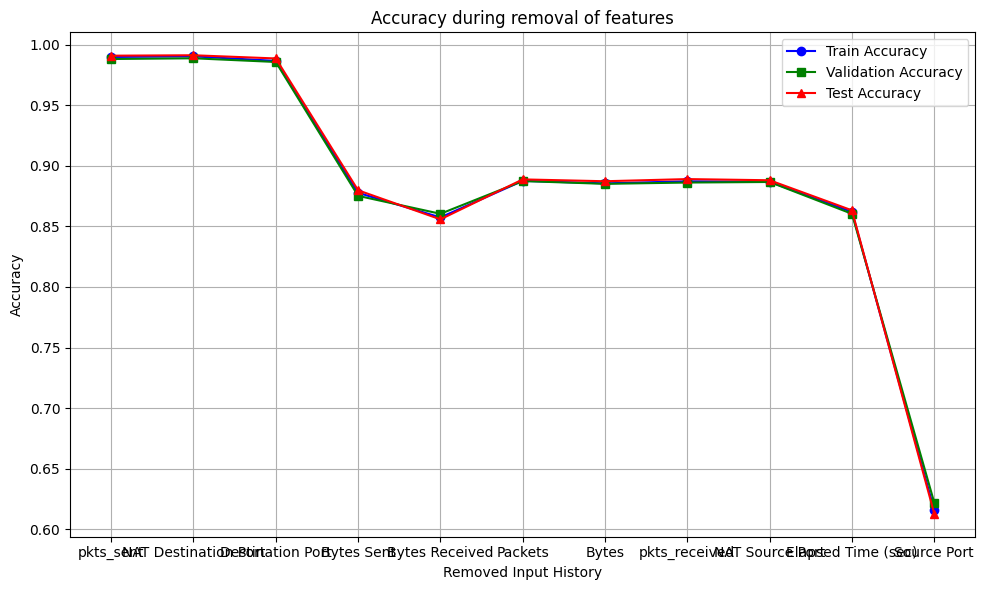

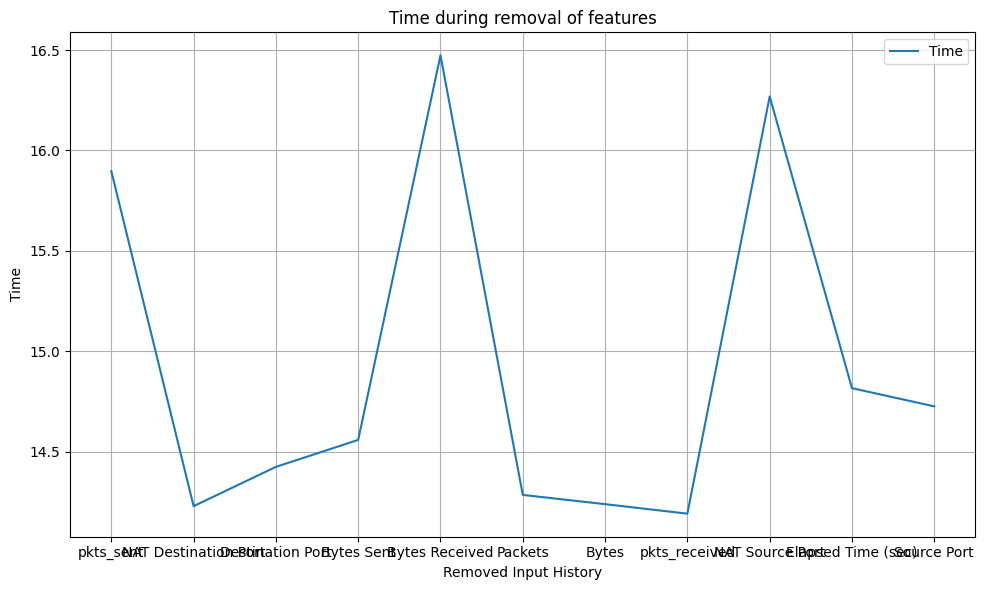

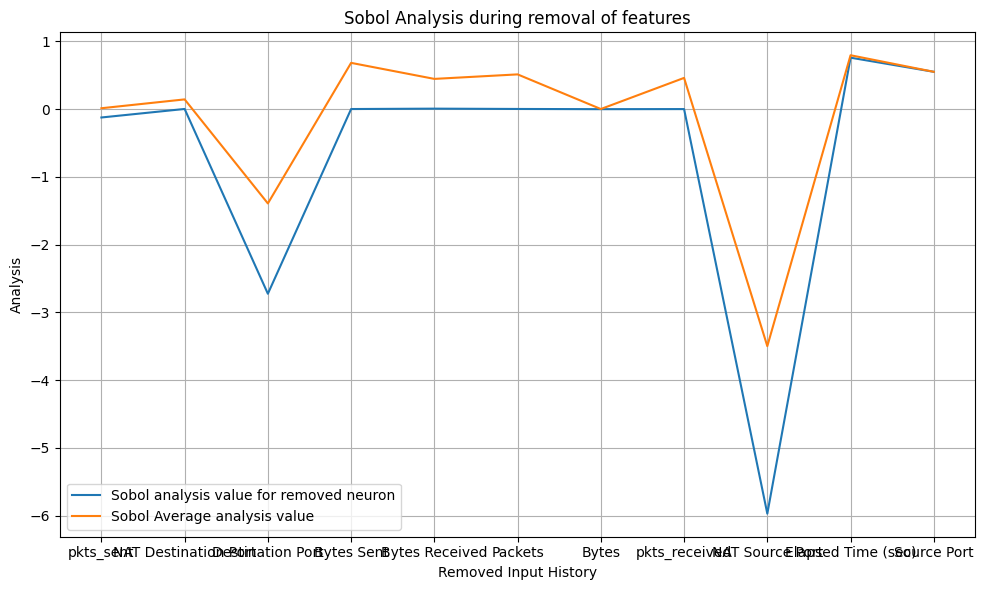

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_first_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_first_sobol)
print("time_history:")
print(time_history_first_sobol)
plot_accuracy(removed_inputs_history_first_sobol, train_accuracy_history_first_sobol, valid_accuracy_history_first_sobol, test_accuracy_history_first_sobol)
plot_time(removed_inputs_history_first_sobol, time_history_first_sobol)
plot_analysis(removed_inputs_history_first_sobol, analysis_history_first_sobol, average_analysis_history_first_sobol, "Sobol")

# Usuwanie neuronów z drugiej warstwy - SOBOL


In [ ]:
import os
if not os.path.exists('firewall_data.zip'):
    # If the file doesn't exist, download it
  !pip install wget
  !wget https://archive.ics.uci.edu/static/public/542/internet+firewall+data.zip -O firewall_data.zip
  !unzip firewall_data.zip

import pandas as pd

data = pd.read_csv('log2.csv')

data.dropna(inplace=True)

label_encoder = LabelEncoder()
data['Action'] = label_encoder.fit_transform(data['Action'])

X = data.drop('Action', axis=1)
X = X.drop('pkts_sent', axis=1)
X = X.drop('NAT Destination Port', axis=1)

y = data['Action']


hidden_dim = 32
removed_inputs_history_second_sobol, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol, time_history_second_sobol, analysis_history_second_sobol, average_analysis_history_second_sobol = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.SOBOL)

---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.0050, Training Accuracy: 0.9911, Valid Accuracy: 0.9899, Test Accuracy: 0.9918
[Sobol] Dropping neuron with index 27 |  Sobol value =  -0.00015 | Avg Sobol value: 0.25036

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.0072, Training Accuracy: 0.9915, Valid Accuracy: 0.9902, Test Accuracy: 0.9925
[Sobol] Dropping neuron with index 25 |  Sobol value =  -5.53737 | Avg Sobol value: -2.24288

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.0053, Training Accuracy: 0.9909, Valid Accuracy: 0.9892, Test Accuracy: 0.9917
[Sobol] Dropping neuron with index 7 |  Sobol value =  -0.00047 | Avg Sobol value: 0.27803

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.0052, Training Accuracy: 0.9909, Valid Accuracy: 0.9896, Test Accuracy: 0.99

removed_inputs_history:
[27, 25, 7, 25, 15, 1, 19, 9, 3, 5, 11, 17, 7, 5, 3, 1, 7, 13, 7, 1, 3, 5, 3, 1, 3, 5, 3, 1, 3, 0, 1, 0]
train_accuracy_history:
[0.9910730181337267, 0.9915053790788169, 0.9909458531498766, 0.9909458531498766, 0.9909458531498766, 0.9910221521401866, 0.9909204201531067, 0.9909204201531067, 0.9909712861466466, 0.9909458531498766, 0.9914545130852769, 0.9912510491111167, 0.9912256161143468, 0.9909967191434167, 0.9909712861466466, 0.9908186881660266, 0.9908949871563366, 0.9903863272209364, 0.9911238841272667, 0.9901828632467764, 0.9904880592080165, 0.9908949871563366, 0.9905389252015565, 0.9898268012919962, 0.989140110379206, 0.9895979043210662, 0.9880464915180955, 0.9898522342887662, 0.9884534194664157, 0.9846639029476844, 0.975736921081411, 0.9596887001195351]
valid_accuracy_history:
[0.9899282771249809, 0.9902334808484663, 0.9891652678162673, 0.9896230734014955, 0.9899282771249809, 0.9896230734014955, 0.9897756752632382, 0.9894704715397528, 0.9894704715397528, 0.9

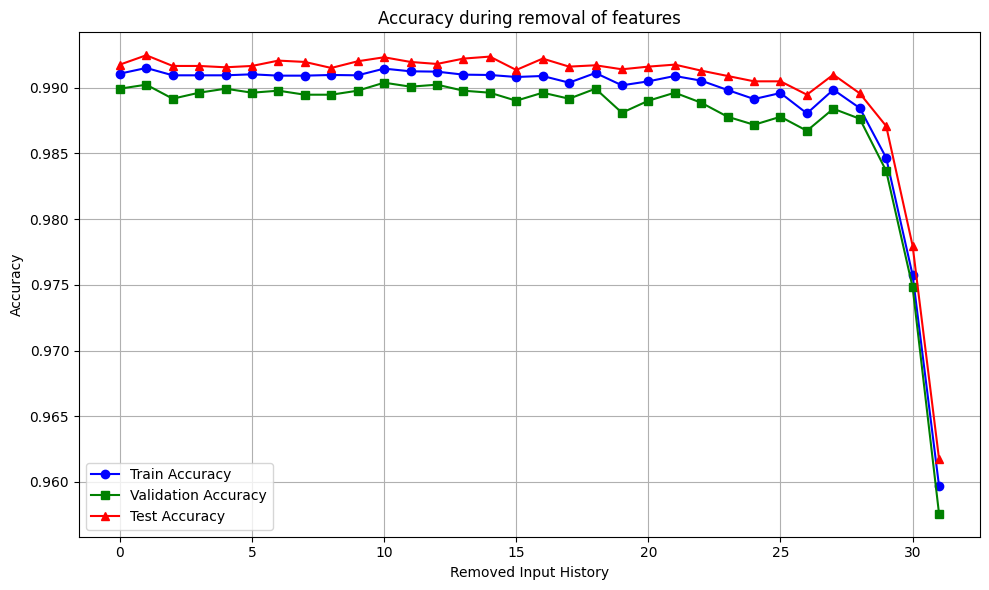

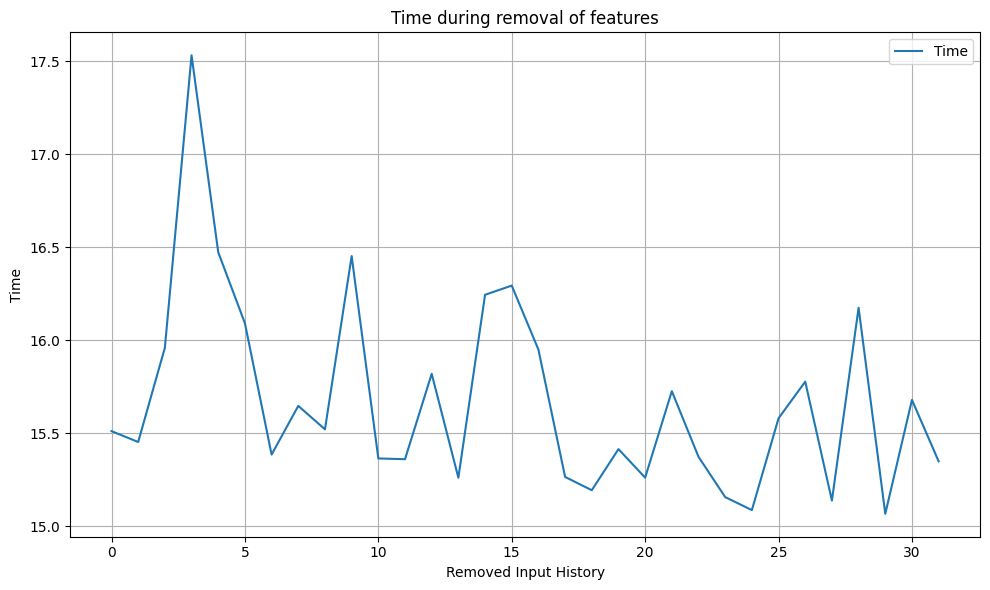

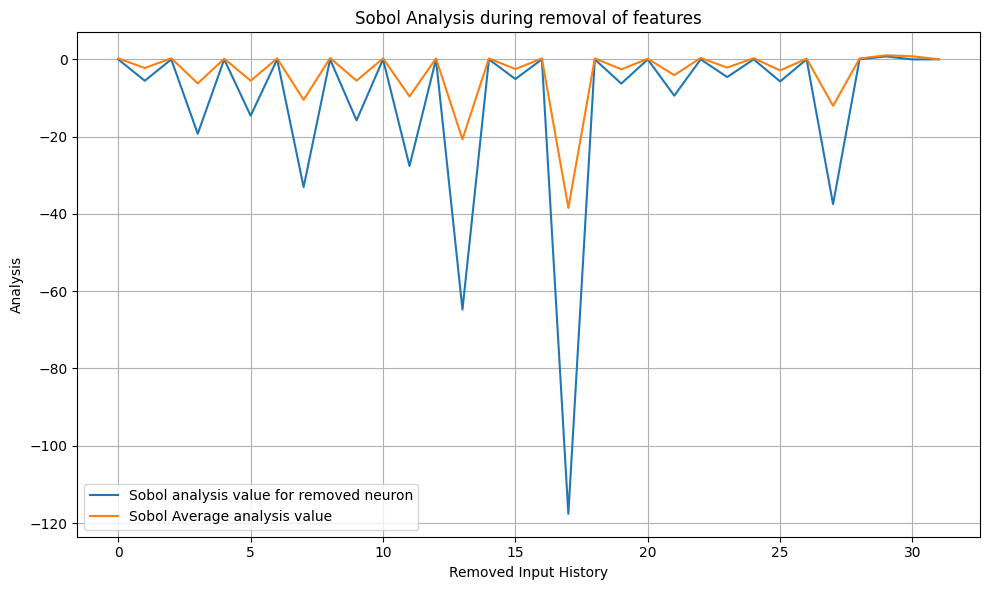

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_sobol)
print("train_accuracy_history:")
print(train_accuracy_history_second_sobol)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_sobol)
print("test_accuracy_history:")
print(test_accuracy_history_second_sobol)
print("time_history:")
print(time_history_second_sobol)
plot_accuracy(None, train_accuracy_history_second_sobol, valid_accuracy_history_second_sobol, test_accuracy_history_second_sobol)
plot_time(None, time_history_second_sobol)
plot_analysis(None, analysis_history_second_sobol, average_analysis_history_second_sobol, "Sobol")

# Usuwanie neuronów z pierwszej warstwy - PAWN

In [ ]:
import os
if not os.path.exists('firewall_data.zip'):
    # If the file doesn't exist, download it
  !pip install wget
  !wget https://archive.ics.uci.edu/static/public/542/internet+firewall+data.zip -O firewall_data.zip
  !unzip firewall_data.zip

import pandas as pd

data = pd.read_csv('log2.csv')

data.dropna(inplace=True)

label_encoder = LabelEncoder()
data['Action'] = label_encoder.fit_transform(data['Action'])

X = data.drop('Action', axis=1)
zero_columns = X.columns[X.eq(0).any()]
small_value = 1e-8
X[zero_columns] = X[zero_columns].replace(0, small_value)

y = data['Action']

hidden_dim = 4
removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn, time_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn = trainWhileRemovingInputsBasedOnAnalysisForFirstLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.0070, Training Accuracy: 0.9896, Valid Accuracy: 0.9881, , Test Accuracy: 0.9906


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


[PAWN] Dropping neuron with index 0 (column: Source Port) |  PAWN value =  nan | Avg PAWN value: nan 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.0150, Training Accuracy: 0.9813, Valid Accuracy: 0.9794, , Test Accuracy: 0.9814
[PAWN] Dropping neuron with index 8 (column: pkts_sent) |  PAWN value =  0.43693 | Avg PAWN value: 0.73662 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.0186, Training Accuracy: 0.9828, Valid Accuracy: 0.9814, , Test Accuracy: 0.9821
[PAWN] Dropping neuron with index 3 (column: Bytes) |  PAWN value =  0.49257 | Avg PAWN value: 0.76669 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.0171, Training Accuracy: 0.9830, Valid Accuracy: 0.9815, , Test Accuracy: 0.9827
[PAWN] Dropping neuron with index 7 (column: pkts_received) |  PAWN value =  0.41505 | Avg PAWN value: 0.75199 

---------------------

/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 0.2925, Training Accuracy: 0.8014, Valid Accuracy: 0.8033, , Test Accuracy: 0.7975
[PAWN] Dropping neuron with index 0 (column: NAT Source Port) |  PAWN value =  nan | Avg PAWN value: nan 

---------------------------------------- Iteration 7 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 0.2935, Training Accuracy: 0.8016, Valid Accuracy: 0.8041, , Test Accuracy: 0.7970
[PAWN] Dropping neuron with index 0 (column: NAT Destination Port) |  PAWN value =  nan | Avg PAWN value: nan 

---------------------------------------- Iteration 8 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 0.2985, Training Accuracy: 0.7979, Valid Accuracy: 0.7993, , Test Accuracy: 0.7935
[PAWN] Dropping neuron with index 0 (column: Bytes Sent) |  PAWN value =  nan | Avg PAWN value: nan 

---------------------------------------- Iteration 9 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 0.2986, Training Accuracy: 0.7979, Valid Accuracy: 0.7993, , Test Accuracy: 0.7935
[PAWN] Dropping neuron with index 0 (column: Bytes Received) |  PAWN value =  nan | Avg PAWN value: nan 

---------------------------------------- Iteration 10 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 0.3016, Training Accuracy: 0.7979, Valid Accuracy: 0.7993, , Test Accuracy: 0.7935
[PAWN] Dropping neuron with index 0 (column: Packets) |  PAWN value =  nan | Avg PAWN value: nan 

---------------------------------------- Iteration 11 ----------------------------------------


/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


Loss: 0.2999, Training Accuracy: 0.7978, Valid Accuracy: 0.7993, , Test Accuracy: 0.7935
[PAWN] Dropping neuron with index 0 (column: Elapsed Time (sec)) |  PAWN value =  nan | Avg PAWN value: nan 



/usr/local/lib/python3.10/dist-packages/SALib/analyze/pawn.py:142: RuntimeWarning: invalid value encountered in scalar divide
  cv = np.nanstd(p_ind) / mean


removed_inputs_history:
['Source Port', 'pkts_sent', 'Bytes', 'pkts_received', 'Destination Port', 'NAT Source Port', 'NAT Destination Port', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)']
train_accuracy_history:
[0.9896233373178361, 0.981332180370813, 0.9827564281899336, 0.9830107581576337, 0.9813067473740431, 0.8013937282229965, 0.8015717592003866, 0.7978585416719652, 0.7979348406622753, 0.7979348406622753, 0.7978331086751952]
valid_accuracy_history:
[0.9880970547840684, 0.9793987486647338, 0.981382572867389, 0.9815351747291317, 0.9795513505264765, 0.8032962002136426, 0.8040592095223562, 0.7993285518083321, 0.7993285518083321, 0.7993285518083321, 0.7993285518083321]
test_accuracy_history:
[0.9906408952187182, 0.9813835198372329, 0.982146490335707, 0.982706002034588, 0.9812817904374365, 0.7975076297049848, 0.7970498474059003, 0.7935401831129196, 0.7935401831129196, 0.7935401831129196, 0.7935401831129196]
time_history:
[14.663750171661377, 14.54926586151123, 14.553381

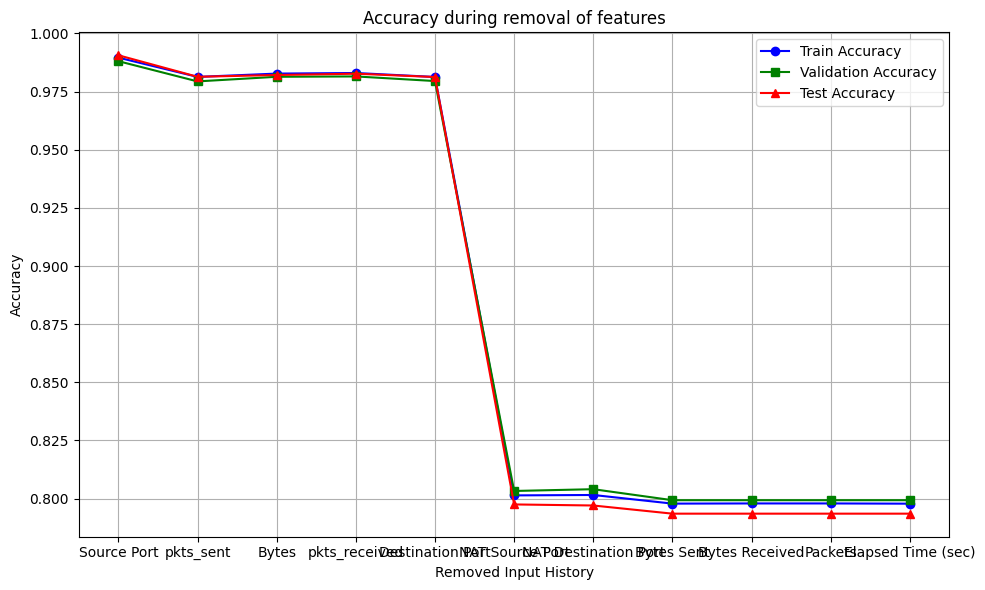

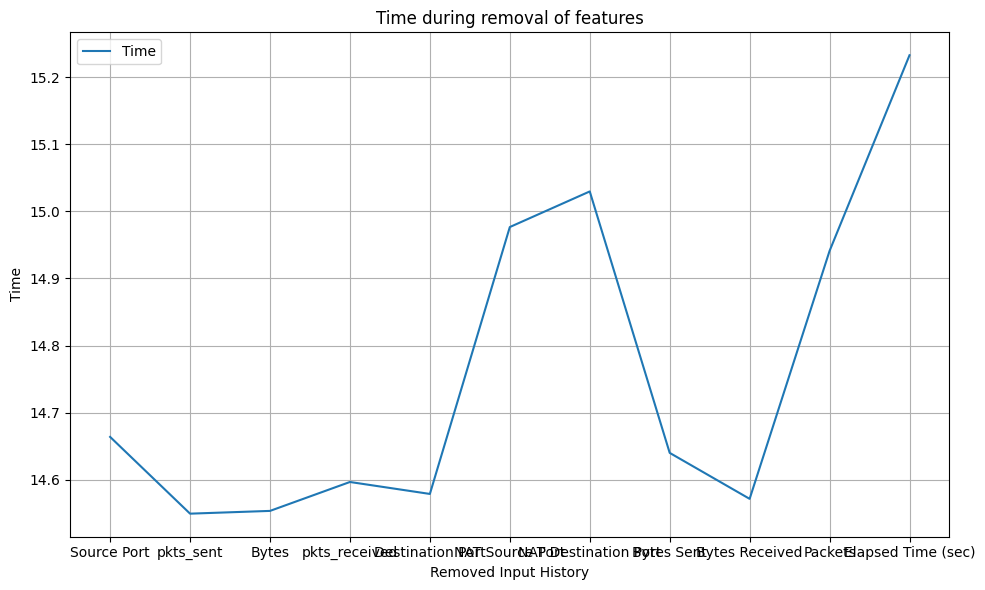

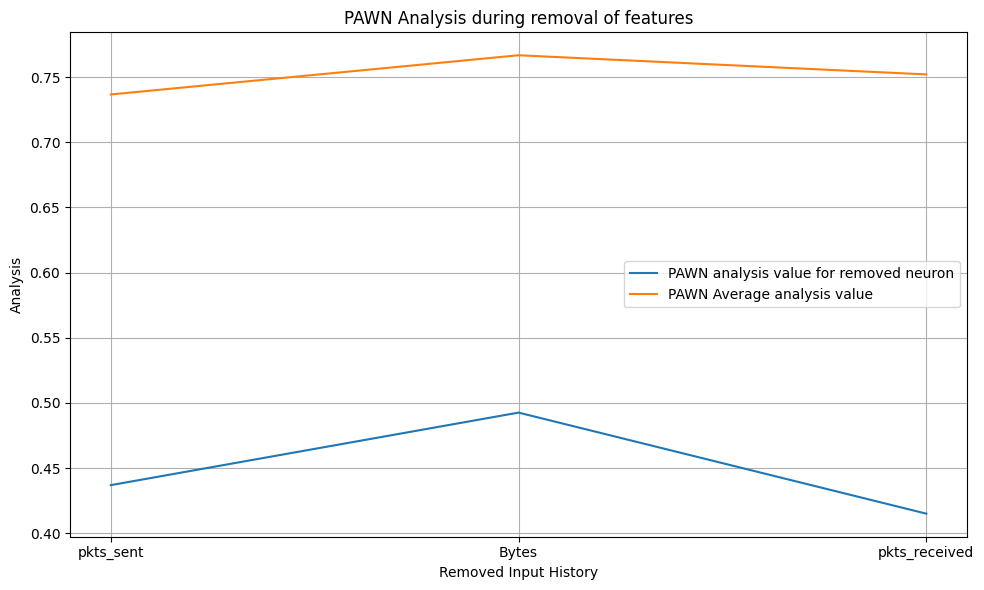

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_first_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_first_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_first_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_first_pawn)
print("time_history:")
print(time_history_first_pawn)
plot_accuracy(removed_inputs_history_first_pawn, train_accuracy_history_first_pawn, valid_accuracy_history_first_pawn, test_accuracy_history_first_pawn)
plot_time(removed_inputs_history_first_pawn, time_history_first_pawn)
plot_analysis(removed_inputs_history_first_pawn, analysis_history_first_pawn, average_analysis_history_first_pawn, "PAWN")

# Usuwanie neuronów z drugiej warstwy - PAWN

In [ ]:
import os
if not os.path.exists('firewall_data.zip'):
    # If the file doesn't exist, download it
  !pip install wget
  !wget https://archive.ics.uci.edu/static/public/542/internet+firewall+data.zip -O firewall_data.zip
  !unzip firewall_data.zip

import pandas as pd

data = pd.read_csv('log2.csv')

data.dropna(inplace=True)

label_encoder = LabelEncoder()
data['Action'] = label_encoder.fit_transform(data['Action'])

X = data.drop('Action', axis=1)
X = X.drop('Source Port', axis=1)
X = X.drop('pkts_sent', axis=1)
X = X.drop('Bytes', axis=1)
X = X.drop('pkts_received', axis=1)

zero_columns = X.columns[X.eq(0).any()]
small_value = 1e-8
X[zero_columns] = X[zero_columns].replace(0, small_value)

y = data['Action']

hidden_dim = 4
removed_inputs_history_second_pawn, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn, time_history_second_pawn, analysis_history_second_pawn, average_analysis_history_second_pawn = trainWhileRemovingInputsBasedOnAnalysisForSecondLayer(X, y, hidden_dim, AnalysisMethod.PAWN)

---------------------------------------- Iteration 1 ----------------------------------------
Loss: 0.0178, Training Accuracy: 0.9811, Valid Accuracy: 0.9794, Test Accuracy: 0.9812
[PAWN] Dropping neuron with index 3 |  PAWN value =  0.03421 | Avg PAWN value: 0.04761 

---------------------------------------- Iteration 2 ----------------------------------------
Loss: 0.0169, Training Accuracy: 0.9802, Valid Accuracy: 0.9782, Test Accuracy: 0.9803
[PAWN] Dropping neuron with index 2 |  PAWN value =  0.05122 | Avg PAWN value: 0.06440 

---------------------------------------- Iteration 3 ----------------------------------------
Loss: 0.2951, Training Accuracy: 0.8012, Valid Accuracy: 0.8038, Test Accuracy: 0.7967
[PAWN] Dropping neuron with index 0 |  PAWN value =  0.12114 | Avg PAWN value: 0.13975 

---------------------------------------- Iteration 4 ----------------------------------------
Loss: 0.0372, Training Accuracy: 0.9753, Valid Accuracy: 0.9742, Test Accuracy: 0.9754
[PAWN] Dr

removed_inputs_history:
[18, 24, 28, 26, 12, 11, 16, 18, 16, 6, 21, 6, 14, 17, 4, 7, 12, 9, 9, 8, 6, 7, 6, 0, 1, 0, 4, 2, 1, 0, 1, 0]
train_accuracy_history:
[0.9485416666666666, 0.94625, 0.949375, 0.946875, 0.9460416666666667, 0.9470833333333334, 0.9475, 0.95, 0.9454166666666667, 0.945625, 0.9454166666666667, 0.9402083333333333, 0.944375, 0.9464583333333333, 0.9425, 0.94, 0.943125, 0.9414583333333333, 0.938125, 0.9377083333333334, 0.9389583333333333, 0.9370833333333334, 0.9372916666666666, 0.9379166666666666, 0.9364583333333333, 0.9339583333333333, 0.9279166666666666, 0.9395833333333333, 0.92625, 0.9039583333333333, 0.8408333333333333, 0.7977083333333334]
valid_accuracy_history:
[0.9425, 0.93375, 0.93625, 0.93625, 0.93375, 0.93625, 0.93875, 0.93625, 0.9375, 0.93625, 0.9325, 0.93, 0.93125, 0.93625, 0.9325, 0.93, 0.93125, 0.925, 0.92625, 0.92, 0.92875, 0.92625, 0.92875, 0.92, 0.91875, 0.91875, 0.92625, 0.9325, 0.91875, 0.89875, 0.83, 0.77375]
test_accuracy_history:
[0.94375, 0.939583333

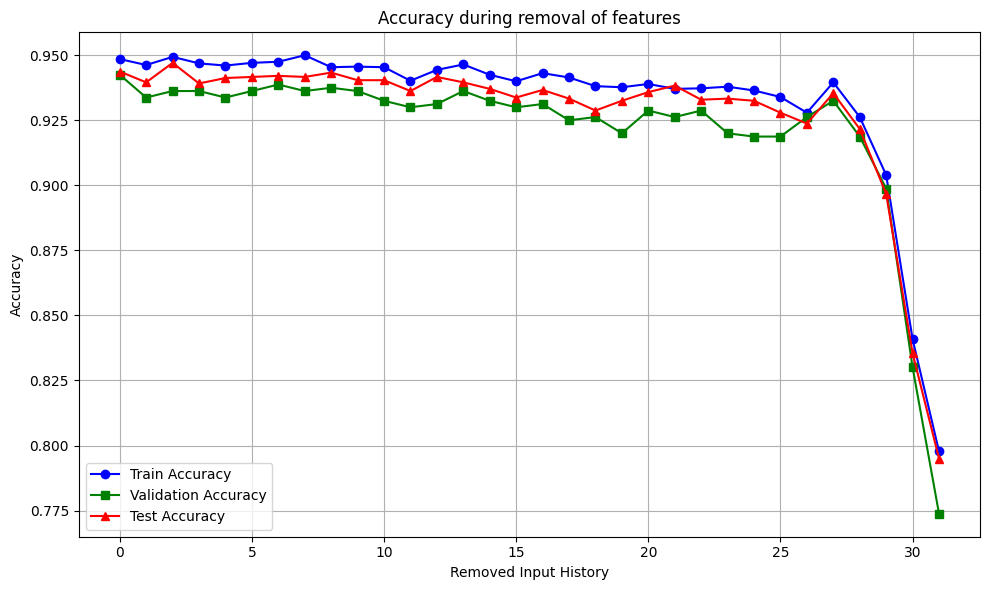

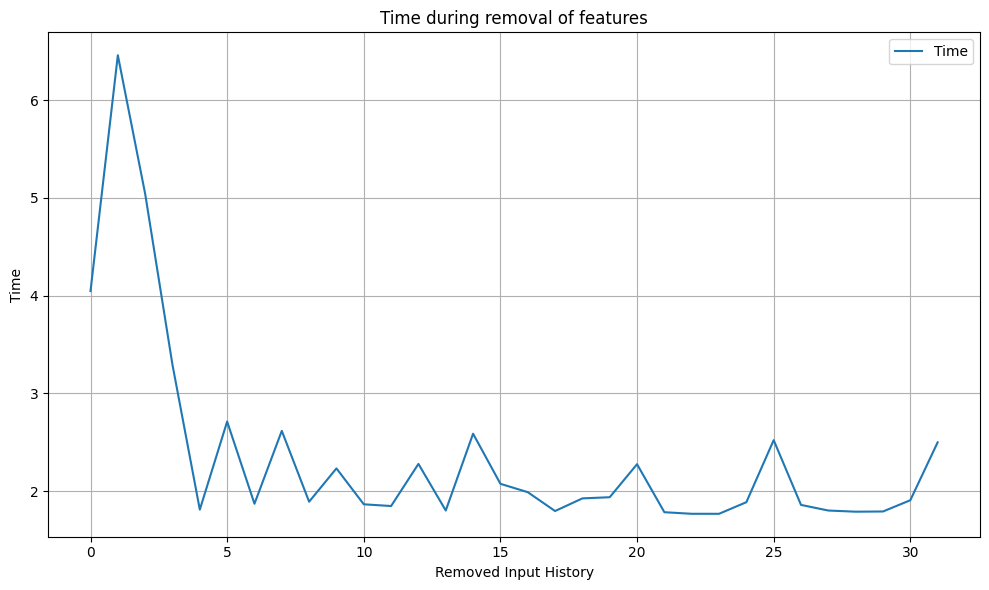

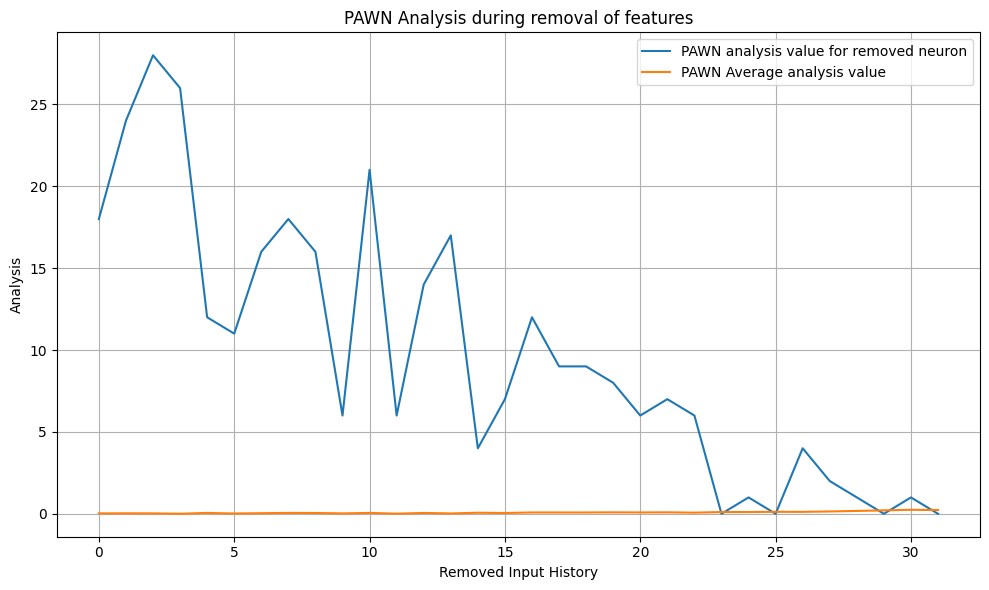

In [ ]:
print("removed_inputs_history:")
print(removed_inputs_history_second_pawn)
print("train_accuracy_history:")
print(train_accuracy_history_second_pawn)
print("valid_accuracy_history:")
print(valid_accuracy_history_second_pawn)
print("test_accuracy_history:")
print(test_accuracy_history_second_pawn)
print("time_history:")
print(time_history_second_pawn)
plot_accuracy(None, train_accuracy_history_second_pawn, valid_accuracy_history_second_pawn, test_accuracy_history_second_pawn)
plot_time(None, time_history_second_pawn)
plot_analysis(None, analysis_history_second_pawn, average_analysis_history_second_pawn, "PAWN")